# Introduction

This notebook details the structure of the library which will become common APIs for all methods as well as wrapper to help run the benchmark.

In [1]:
# path imports
import os
import sys

# Get the repo base path assuming you're in a notebook at root or in a subfolder
repo_root = os.path.abspath(os.path.join(os.getcwd(), ''))  # or add '..' to go up

# Add the benchmarks subdir to sys.path
bench_path = os.path.join(repo_root, 'benchmarks')
ddgclib_path = os.path.join(repo_root, 'ddgclib')
if [bench_path, ddgclib_path] not in sys.path:
    sys.path.append(bench_path)

## Base class for testing a collection of methods
First we import the `GeometryBenchmarkBase` class which is the base class for running a method on all benchmarks classes, and the `run_all_benchmarks` function which is used to run all benchmarks in the library.

For comparing different methods, every method should initiated its own class.

In [2]:
from benchmarks._benchmark_classes import run_all_benchmarks, GeometryBenchmarkBase

run_all_benchmarks

<function benchmarks._benchmark_classes.run_all_benchmarks(benchmark_classes: Iterable[type], method: Optional[Dict[str, str]] = None, complex_dtype: str = 'vf') -> None>

## Method Wrappers

In the cell below we speficy the example template methods, all available methods are saved in the `ddgclib._method_wrappers` module. The methods are used to compute curvature, area, and volume of the simplicial complexes.

E.g. currently there are template methods like:

```python
_curvature_i_methods = {
    "laplace-beltrami": compute_laplace_beltrami,
}

_area_i_methods = {
    "default": compute_area_vertex_default,
}

_area_ijk_methods = {
    "default": compute_area_triangle_default,
}

_area_methods = {
    "default": compute_area_triangle_default,
}

_volume_methods = {
    "default": compute_volume_default,
}
```

so we can specify a methods dict like:

In [3]:
method = {
    "curvature_i_method": "laplace-beltrami",
    "area_i_method": "default",
    "area_ijk_method": "default",
    "area_method": "default",
    "volume_method": "default",
}


The second important parameter is the `complex_dtype` which specifies the data type of the simplicial complex. It can be a hypect Complex object ('vv') or a tuple of numpy arrays (vertices, simplices) specified using 'vf' such as we have with `scipy`'s `Delaunay` function. The latter is intended for methods which cannot use dual vertices for whatever reason.

The final class can then be called like:

In [4]:
GeometryBenchmarkBase(method=method, complex_dtype='vv')

INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet


In [5]:
from ddgclib._method_wrappers import Curvature_i, Area_i, Area_ijk, Volume
curvature_i = Curvature_i()
area_i = Area_i()
area_ijk = Area_ijk()
volume = Volume()

## Geometry Benchmark Framework Overview

This section demonstrates the structure of a case geometry benchmark system designed to evaluate curvature, surface area, and volume computations on 3D simplicial complexes. Each benchmark case corresponds to a known geometry with analytical expressions.

---

## Required Functions for Any Benchmark Case

Each benchmark case (e.g., `TorusBenchmark`) should inherit from `GeometryBenchmarkBase` and implement the following:

### 1. `generate_mesh()`
Generates the mesh (vertices and simplices). For `'vf'` style, this is a 2-array representation:

```python
self.points      # shape (N, 3)
self.simplices   # shape (M, 3)
```

## Additional Analytical Tools (Implemented Per Benchmark)

These functions provide analytical evaluations to support local accuracy assessments. Each benchmark class should implement them when possible.

### `f(u, v)`

The parametric surface map $f:\mathbb{R}^2 \rightarrow \mathbb{R}^3$ from 2D domain to 3D:

$$
f(u, v) = (x(u, v), y(u, v), z(u, v))
$$

This maps a parametric domain (e.g., a UV grid) to the embedded 3D surface used for benchmarking.

---

### `H(u, v)`

Pointwise analytical **mean curvature**:

$$
H(u, v) = \text{analytical expression for mean curvature at } (u, v)
$$

This is used for comparing local curvature errors per vertex or triangle.

---

### `dA(uv_i, uv_j, uv_k)`

Computes the **integrated surface area** over a parametric triangle:

$$
\int_{\Omega} dA
$$

where \( \Omega \) is the triangle defined by parametric vertices \( uv_i, uv_j, uv_k \).

---

### `HNdA(uv_i, uv_j, uv_k)`

Computes the *integrated mean normal curvature* over a triangle area domain:

$$
\int_{\Omega} H(u, v) \bf{N} dA
$$

Useful for comparing discrete integrated curvature per simplex against analytical values.


## Visualization

Optionally all the test cases should have a simple visualization of the geometry, this will be especially later useful when we convert these to polyscope to better visualize local errors on the geometry.

INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet


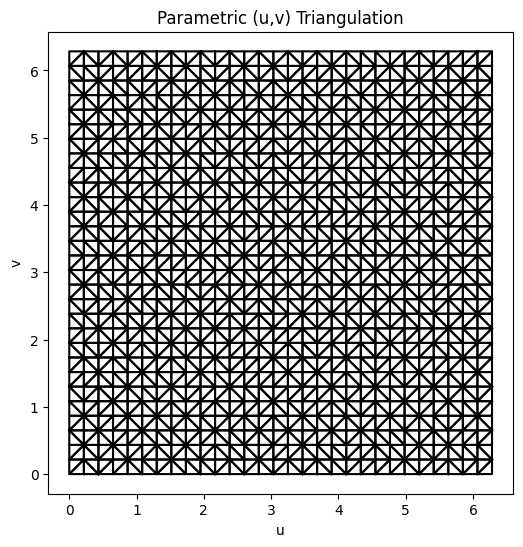

In [6]:
from benchmarks._benchmark_cases import TorusBenchmark

# Instantiate the benchmark
torus = TorusBenchmark(
    R_major=2.0,
    r_minor=1.0,
    n_u=30,
    n_v=30,
    method={  # method dict with per-quantity control
        "curvature_i_method": "laplace-beltrami",
        "area_i_method": "default",
        "area_ijk_method": "default",
        "area_method": "default",
        "volume_method": "default",
    },
    complex_dtype="vf"
)

# Torus generate mesh
torus.generate_mesh()
# Plot parametric (u,v) triangulation
torus.plot_uv_triangulation()


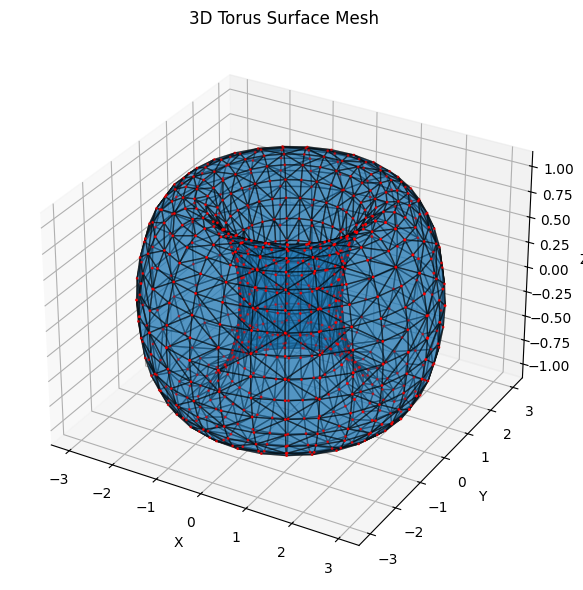

In [7]:

# Plot 3D surface mesh
torus.plot_surface_mesh()

In [8]:
import sys, subprocess, pkgutil

def ensure(pkg):
    if pkgutil.find_loader(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg])

for pkg in ["meshio", "pandas", "scipy", "numpy"]:
    ensure(pkg)

import meshio, pandas, scipy, numpy as np
print("OK — using", sys.executable)


/var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/ipykernel_17594/2299717732.py:4: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(pkg) is None:


OK — using /usr/local/bin/python3.13


## 1. Circular Cylinder

In [9]:
#!pip install meshio pandas scipy numpy

import importlib
import ddgclib._method_wrappers as mw
importlib.reload(mw)

from benchmarks._benchmark_cases import MshCase

method = {"volume_method": "curved_volume", "curvature_i_method": "laplace-beltrami"}
bench = MshCase(msh_path="test_cases/cylinder.msh", method=method, complex_dtype="vf")
bench.run_benchmark()
bench.summary()

# ---- added lines: relative error vs theoretical volume (π) ----
V_theory = 3.14159265
print("**************************************************\nrelative error {:.6f}%\n**************************************************"
      .format((bench.volume_computed - V_theory) / V_theory * 100))


INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet




[triangles] explicit surface faces: 374 (from 1 block(s))
[mesh] points=229  surface_triangles=374
[smooth] components: 3 (theta_max=35.0°)
[write] CSV -> /private/var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmp_hxjy0xg/mesh_COEFFS.csv  (rows kept=180, skipped_flat=194, total_tris=374)
[ok] Non-planar ABC rows written.
Saved: trn_Volume.csv
Sum of Vcorrection_scal = 0.033595611439
Sum of Vcorrection = 0.033595611439
Rows: 180, Elapsed: 0.04 s
**************************************************
relative error 0.000004%
**************************************************


## 2. Hyperboloid

In [10]:
import importlib
import ddgclib._method_wrappers as mw
importlib.reload(mw)

from benchmarks._benchmark_cases import MshCase

method = {"volume_method": "curved_volume", "curvature_i_method": "laplace-beltrami"}
bench = MshCase(msh_path="test_cases/coarse_hyperboloid.msh", method=method, complex_dtype="vf")
bench.run_benchmark()
bench.summary()

# ---- relative error vs theoretical volume (coarse_hyperboloid) ----
V_theory = 8.37758041
print("**************************************************\nrelative error {:.6f}%\n**************************************************"
      .format((bench.volume_computed - V_theory) / V_theory * 100))


INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet




[triangles] explicit surface faces: 238 (from 1 block(s))
[mesh] points=129  surface_triangles=238
[smooth] components: 3 (theta_max=35.0°)
[write] CSV -> /private/var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmp6q5xz7bt/mesh_COEFFS.csv  (rows kept=124, skipped_flat=114, total_tris=238)
[ok] Non-planar ABC rows written.
[input] /var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmpyhkf7kfg/rot.csv
Triangles kept (curved): 124 | planar skipped: 0
Patch-based total (sum of patches): 0.07943469
Total elapsed: 0.49 s
[write] /private/var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmpyhkf7kfg/rot_Volume.csv
**************************************************
relative error 0.039775%
**************************************************


## 3. Paraboloid

In [11]:
import importlib
import ddgclib._method_wrappers as mw
importlib.reload(mw)

from benchmarks._benchmark_cases import MshCase

method = {"volume_method": "curved_volume", "curvature_i_method": "laplace-beltrami"}
bench = MshCase(msh_path="test_cases/coarse_paraboloid.msh", method=method, complex_dtype="vf")
bench.run_benchmark()
bench.summary()

# ---- relative error vs theoretical volume (coarse_paraboloid) ----
V_theory = 6.28318531
print("**************************************************\nrelative error {:.6f}%\n**************************************************"
      .format((bench.volume_computed - V_theory) / V_theory * 100))


INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet




[triangles] explicit surface faces: 174 (from 1 block(s))
[mesh] points=97  surface_triangles=174
[smooth] components: 2 (theta_max=35.0°)
[write] CSV -> /private/var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmpk8i_4_97/mesh_COEFFS.csv  (rows kept=117, skipped_flat=57, total_tris=174)
[ok] Non-planar ABC rows written.
[input] /var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmpbni9m6h_/rot.csv
Triangles kept (curved): 117 | planar skipped: 0
Patch-based total (sum of patches): 0.28162543
Total elapsed: 0.08 s
[write] /private/var/folders/_6/wgp09jqs6h3fw0642d0xywmm0000gn/T/tmpbni9m6h_/rot_Volume.csv
**************************************************
relative error 0.028750%
**************************************************


## 4. Parabolic Cylinder

In [12]:
import importlib, io, re, contextlib
import ddgclib._method_wrappers as mw
importlib.reload(mw)

from benchmarks._benchmark_cases import MshCase

method = {"volume_method": "curved_volume", "curvature_i_method": "laplace-beltrami"}
bench = MshCase(msh_path="test_cases/parabolic_cylinder_y_eq_x2_y1slice.msh",
                method=method, complex_dtype="vf")

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    bench.run_benchmark()
bench.summary()

m = re.search(r"Sum of Vcorrection\s*=\s*([0-9eE\.\+\-]+)", buf.getvalue())
Vcorr = float(m.group(1)) if m else float("nan")

Vflat    = 7.44963674
V_theory = 7.54247233
Vtotal   = Vflat + Vcorr
rel      = (Vtotal - V_theory) / V_theory * 100.0

print("**************************************************")
print(f"Vflat={Vflat:.8f}, Vcorr={Vcorr:.8f}, Vtotal={Vtotal:.8f}")
print(f"relative error {rel:.6f}%")
print("**************************************************")


INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet


**************************************************
Vflat=7.44963674, Vcorr=0.09282729, Vtotal=7.54246403
relative error -0.000110%
**************************************************


## 5. Hyperbolic Cylinder

In [13]:

import importlib, io, re, contextlib
import ddgclib._method_wrappers as mw
importlib.reload(mw)

from benchmarks._benchmark_cases import MshCase

method = {"volume_method": "curved_volume", "curvature_i_method": "laplace-beltrami"}
bench = MshCase(msh_path="test_cases/hyperbola_cylinder_x2_minus_y2_z1slice.msh",
                method=method, complex_dtype="vf")

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    bench.run_benchmark()
bench.summary()

m = re.search(r"Sum of Vcorrection\s*=\s*([0-9eE\.\+\-]+)", buf.getvalue())
Vcorr = float(m.group(1)) if m else float("nan")

Vflat    = 12.10482688
V_theory = 12.16845714
Vtotal   = Vflat + Vcorr
rel      = (Vtotal - V_theory) / V_theory * 100.0

print("**************************************************")
print(f"Vflat={Vflat:.8f}, Vcorr={Vcorr:.8f}, Vtotal={Vtotal:.8f}")
print(f"relative error {rel:.6f}%")
print("**************************************************")



INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet


**************************************************
Vflat=12.10482688, Vcorr=0.06359680, Vtotal=12.16842368
relative error -0.000275%
**************************************************


# 6 Ellipsoid

In [14]:
import importlib, io, re, contextlib, ddgclib._method_wrappers as mw
importlib.reload(mw)

from benchmarks._benchmark_cases import MshCase

method = {"volume_method": "curved_volume", "curvature_i_method": "laplace-beltrami"}
bench  = MshCase(msh_path="test_cases/Ellip_0_sub0_full.msh", method=method, complex_dtype="vf")

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    bench.run_benchmark()
log = buf.getvalue()

# Prefer scaled, else unscaled; fall back to bench.volume_computed (ellipsoid path returns Vcorr)
m = (re.search(r"Sum of Vcorrection_scal\s*=\s*([0-9eE\.\+\-]+)", log)
     or re.search(r"Sum of Vcorrection\s*=\s*([0-9eE\.\+\-]+)", log))
Vcorr = float(m.group(1)) if m else float(bench.volume_computed)

# Your references for this mesh
Vflat, V_theory = 3.04338074, 5.02654825
Vtotal = Vflat + Vcorr
rel    = (Vtotal - V_theory) / V_theory * 100.0

print("**************************************************")
print(f"Vflat={Vflat:.8f}, Vcorr={Vcorr:.8f}, Vtotal={Vtotal:.8f}")
print(f"relative error {rel:.6f}%")
print("**************************************************")


INFO:benchmarks._benchmark_classes:curvature_ijk unavailable: Triangle-level curvature not implemented yet


**************************************************
Vflat=3.04338074, Vcorr=1.98316737, Vtotal=5.02654811
relative error -0.000003%
**************************************************
